<a href="https://colab.research.google.com/github/JINU6497/JINUrepo/blob/master/Multi_Layer_Perceptron_by_using_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
'''1. 모듈 임포트'''

import numpy as np  # 선형대수와 관련된 함수를 이용할 수 있게 해주는 모듈
import matplotlib.pyplot as plt  # 함수 실행 결과를 시각화해주는 모듈
import torch
import torch.nn as nn  # 파이토치 모듈 중 인공 신경망 모델을 설계할 때 필요한 함수 모아둔 모듈
import torch.nn.functional as F  # torch.nn 모듈 중에서도 자주 이용되는 함수를 F로 저장
from torchvision import transforms, datasets  # torchvision 모듈 내 transforms, datasets 함수 import

In [77]:
'''2. 딥러닝 모델 설계할 때 활용하는 장비 확인'''

if torch.cuda.is_available():
  DEVICE=torch.device('cuda')
else:
  DEVICE=torch.device('cpu')

print('Using Pytorch version:',torch.__version__,'Device:',DEVICE)

#Using Pytorch version: 1.9.0+cu102 Device: cpu

Using Pytorch version: 1.9.0+cu102 Device: cpu


In [78]:
BATCH_SIZE=32
EPOCHS=10

In [79]:
'''3. MNIST 데이터 다운로드 후, Training set과 Test set 분리'''
train_dataset=datasets.MNIST(root="../data/MNIST",train=True,download=True,transform=transforms.ToTensor()) 
test_dataset=datasets.MNIST(root="../data/MNIST",train=False,transform=transforms.ToTensor())
# MNIST 데이터셋 다운로드, root: 데이터가 저장될 장소를 지정. 여기서 ../은 상위 폴더를 의미한다.
# train: 대상 데이터가 MLP 모델을 학습하기 위해 이용하는 학습용 데이터인지, 테스트 데이터인지 지정
# download: 해당 데이터를 인터넷상에서 다운로드해 이용할 것인지 지정
# transform: MNIST는 사람의 손글씨 데이터로 이미지이다. 이때 다운로드 하며서 이미지 데이터에 대하여 기본적인 전처리를 진행할 수 있는데, 여기서는 ToTensor()를 이용해 tensor형태로 변경. 
# 또한 한 픽셀은 0~255의 스칼라 값으로 구성되는데, 이를 0~1 범위에서 정규화 시켜줌.

train_loader=torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,shuffle=True)
test_loader=torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,shuffle=False)
# 다운로드한 MNIST 데이터셋을 Mini Batch 단위로 분리해 지정. 즉 32개만큼 묶어 1개의 Mini-Batch로 구성.
# dataset: Mini-Batch 단위로 할당하고자 하는 데이터셋을 지정
# batch_size: Mini-Batch 1개 단위를 구성하는 데이터의 개수 지정
# shuffle: 데이터의 순서를 섞고자 할 때 이용. MLP모델이 학습을 진행할 때 Label 정보의 순서를 암기해 학습을 진행할 수 있으므로, 잘못된 방향으로 학습하는 것을 방지하기 위함.

In [80]:
'''4. 데이터 확인'''

for (x_train, y_train) in train_loader:
  print('x_train:',x_train.size(),'type:',x_train.type())
  print('y_train:',y_train.size(),'type:',y_train.type())  
  break

# x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
# 32개의 이미지 데이터가 1개의 Mini-Batch 구성하고 있고 가로 28개, 세로 28개의 픽셀로 구성되며,
# 채널1이므로 그레이스케일로 이뤄진, 즉 흑백으로 이뤄진 이미지 데이터
# y_train: torch.Size([32]) type: torch.LongTensor
# 32개의 이미지 데이터 각각에 label값이 1개씩 존재하기 때문에 32개의 값을 갖고 있다.

x_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


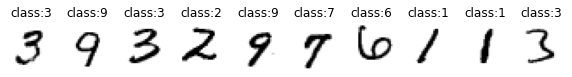

In [81]:
pltsize=1
plt.figure(figsize=(10*pltsize,pltsize))
for i in range(10):
  plt.subplot(1,10,i+1)
  plt.axis('off')
  plt.imshow(x_train[i,:,:,:].numpy().reshape(28,28),cmap='gray_r')
  plt.title('class:'+str(y_train[i].item()))

In [82]:
'''5. MLP 모델 설계'''
class Net(nn.Module):             # nn.module 클래스를 상속받는 Net 클래스 정의. nn.module 클래스를 상속받음으로 nn.module 클래스가 이용할 수 있는 함수를 그대로 이용가능
  def __init__(self):             
    super(Net,self).__init__()    # nn.module 내에 있는 method 상속받아서 이용
    self.fc1=nn.Linear(28*28,512) # 첫번째 Fully connected layer 정의.
    self.fc2=nn.Linear(512,256)
    self.fc3=nn.Linear(256,10)    # 0부터 9까지 총 10가지 class 표현하기 위해 label 값을 10개로 one-hot encording으로 표현. 이후 Loss값 계산에도 용이
  def forward(self,x):            # MLP 모델의 forward propagation 정의
    x=x.view(-1,28*28)            # MLP 모델은 1차원의 벡터 값을 입력으로 받을 수 있으나, MNIST는 크기가 28*28인 이미지 2차원 데이터. 이에 1차원으로 Flatten하게 변환.
    x=self.fc1(x)                 # 첫 번째 fully connected layer에 이미지를 통과시킨다
    x=F.sigmoid(x)                # torch.nn.functional 내에 정의된 비선형 함수인 sigmoid()를 이용하여 두 번째 fully connected layer의 input으로 계산
    x=self.fc2(x)                 # torch.nn.functional 은 pyTorch 중 인공 신경망 설계에 유용한 함수를 모아놓은 것 
    x=F.sigmoid(x)
    x=self.fc3(x)
    x=F.log_softmax(x,dim=1)      # torch.nn.functional 내의 log.softmax이용. softmax가 아니라 이를 이용하는 이유는 MLP모델이 Back propagation알고르짐 이용해 학습할 때 Loss 값에 대한 Gradient 값을 좀 더 원활하게 계산할 수 있기 때문이다.
    return x

In [83]:
'''6. Optimizer, Objective Function설정'''
model = Net().to(DEVICE)         # 위에서 정의한 model을 DEVICE에 할당. GPU로 계산하기 위함
optimizer = torch.optim.SGD(model.parameters() , lr=0.01 , momentum = 0.5) # SGD로 Optimizer 정의. momentum은 optimizer 관성을 의미
criterion = nn.CrossEntropyLoss()  # MLP 모델의 output 값과 계산될 Label은 class를 표현하는 one-hot encording 값. 이때 Loss를 cross entropy이용하여 계산

print(model)

#Net(
#  (fc1): Linear(in_features=784, out_features=512, bias=True)
#  (fc2): Linear(in_features=512, out_features=256, bias=True)
#  (fc3): Linear(in_features=256, out_features=10, bias=True)
#)

Net(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)


In [84]:
'''7. 학습 데이터에 대한 MLP 모델 성능 확인하는 함수 정의'''
def train(model , train_loader , optimizer , log_interval):
  model.train()  # 기존에 정의한 MLP모델을 학습 상태로 지정
  for batch_idx,(image,label) in enumerate(train_loader): # train_loader 내에 Mini-Batch 단위로 저장된 데이터를 순서대로 이용해 MLP모형 학습
    image = image.to(DEVICE)  # 기존에 정의한 장비(GPU)에 할당
    label = label.to(DEVICE)
    optimizer.zero_grad()  # 과거에 이용한 Mini-Batch 내의 이미지 데이터와 레이블 데이터를 바탕으로 계산된 Loss가 할당되어 있으므로 초기화 시켜준다.
    output = model(image)  # 장비에 할당한 이미지 데이터를 MLP 모델의 Input으로 이용해 Output도출
    loss = criterion(output, label)  # Output 데이터와 Label 데이터 이용하여 cross entropy로 loss 도출
    loss.backward()  # back propagation통하여 Gradient값 계산
    optimizer.step()  # 각 parameter에 할당된 gradient 값을 이용해 parameter 업데이트

    if batch_idx % log_interval == 0:
      print('train epoch:{} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}'.format(
          Epoch, batch_idx * len(image),
          len(train_loader.dataset), 100. * batch_idx / len(train_loader),
          loss.item()
      ))

In [85]:
'''8. 검증 데이터에 대한 MLP 모델의 성능 확인하는 함수 정의'''
def evaluate(model, test_loader):  
  model.eval()  # 학습 과정 또는 학습이 완료된 MLP 모델을 평가 상태로 지정
  test_loss = 0  # Loss 값 계산을 위하여 test_loss를 0으로 임시 설정
  correct = 0  # MLP모델이 올바른 Class로 분류한 경우를 세기 위해 correct=0 으로 임시 지정

  with torch.no_grad():  # 평가하는 단계이므로 Gradient를 통해 parameter가 업데이트 되는 현상 방지
    for image, label in test_loader:  # 기존에 정의한 test_loader 내의 데이터도 train_loader와 동일하게 Mini-Batch 단위로 저장되어 있으므로, Mini-Batch 내 이미지 데이터와 레이블 데이터에 차례대로 접근 
      image = image.to(DEVICE)  # GPU에 할당
      label = label.to(DEVICE)
      output = model(image)  # GPU에 할당한 이미지 데이터를 MLP 모델의 Input으로 Output 계산
      test_loss += criterion(output, label).item()  # CrossEntropy를 이용해 loss값을 계산한 결과값을 test_loss에 저장
      prediction = output.max(1, keepdim=True)[1]  # MLP 모델의 Output은 크기가 10인 벡터인데, 계산된 벡터 값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단
      output = model(image)  # GPU에 할당한 이미지 데이터를 MLP 모델의 Input으로 Output 계산
      test_loss += criterion(output, label).item()  # CrossEntropy를 이용해 loss값을 계산한 결과값을 test_loss에 저장
      prediction = output.max(1, keepdim=True)[1]  # MLP 모델의 Output은 크기가 10인 벡터인데, 계산된 벡터 값 내 가장 큰 값인 위치에 대해 해당 위치에 대응하는 클래스로 예측했다고 판단
      correct += prediction.eq(label.view_as(prediction)).sum().item()  # 학습시킨 MLP모델이 최종으로 예측한 클래스 값과 실제 레이블이 의미하는 클래스가 맞으면 맞춘 횟수 저장 
  
  test_loss /= len(test_loader.dataset)  # 현재까지 계산된 test_loss 값을 test_loader 내에 존재하는 Mini-Batch 개수만큼 나눠 평균 Loss값으로 계산
  test_accuracy = 100. * correct/len(test_loader.dataset)  #  얼마나 맞췄는지 계산해 정확도 계산
  return test_loss, test_accuracy

In [86]:
'''9. MLP 학습 실행하면서 Training, Test Set의 Loss 및 Accuracy 확인'''
for Epoch in range(1, EPOCHS+1):
  train(model, train_loader, optimizer, log_interval = 200)  # 정의한 train 함수 실행.
  # model: 기존에 정의한 MLP 모델
  # train_loader: 학습 데이터
  # optimizer: SGD
  # log_interval: 학습이 진행되면서 Mini-Batch의 Index를 이용해 과정을 모니터링할 수 있도록 출력하는 것 의미
  test_loss,test_accuracy = evaluate(model, test_loader)  # 각 Epoch별로 출력되는 Loss 값과 accuracy값 계산
  print('\n[EPOCH:{}], \tTest Loss:{:.4f}, \tTest Accuracy:{:.2f} %\n'.
  format(Epoch, test_loss, test_accuracy))

train epoch:1 [0/60000(0%)]	Train Loss: 2.462306


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


train epoch:1 [6400/60000(11%)]	Train Loss: 2.332918
train epoch:1 [12800/60000(21%)]	Train Loss: 2.308297
train epoch:1 [19200/60000(32%)]	Train Loss: 2.264112
train epoch:1 [25600/60000(43%)]	Train Loss: 2.323621
train epoch:1 [32000/60000(53%)]	Train Loss: 2.304912
train epoch:1 [38400/60000(64%)]	Train Loss: 2.275291
train epoch:1 [44800/60000(75%)]	Train Loss: 2.304893
train epoch:1 [51200/60000(85%)]	Train Loss: 2.294853
train epoch:1 [57600/60000(96%)]	Train Loss: 2.241517

[EPOCH:1], 	Test Loss:0.1398, 	Test Accuracy:32.21 %

train epoch:2 [0/60000(0%)]	Train Loss: 2.209002
train epoch:2 [6400/60000(11%)]	Train Loss: 2.186373
train epoch:2 [12800/60000(21%)]	Train Loss: 2.207806
train epoch:2 [19200/60000(32%)]	Train Loss: 2.101304
train epoch:2 [25600/60000(43%)]	Train Loss: 2.009421
train epoch:2 [32000/60000(53%)]	Train Loss: 1.884526
train epoch:2 [38400/60000(64%)]	Train Loss: 1.750800
train epoch:2 [44800/60000(75%)]	Train Loss: 1.584707
train epoch:2 [51200/60000(85%)]	T